In [57]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import kagglehub
import os
import torch.functional as F
import torch.nn as nn
import seaborn as sns
from torch import optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

# Dataset_Preparation and Sampling

In [58]:
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

Using Colab cache for faster access to the 'flowers-recognition' dataset.


In [59]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)
dataset_path = os.path.join(path, "flowers")
dataset = ImageFolder(root=dataset_path, transform=transform)
print("Total images:", len(dataset))
print("Classes:", dataset.classes)

Total images: 4317
Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [60]:
from torch.utils.data import random_split
train_data, test_data, val_data = random_split(dataset, [0.8, 0.1, 0.1])
train_dataset = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataset = DataLoader(test_data, shuffle=True)
val_dataset = DataLoader(val_data, shuffle=True)

In [61]:
images, label = next(iter(train_dataset))
print(images.permute(0,2,3,1).reshape(images.size(0), -1).shape)
images, label = next(iter(val_dataset))
print(images.permute(0,2,3,1).reshape(images.size(0), -1).shape)

torch.Size([32, 150528])
torch.Size([1, 150528])


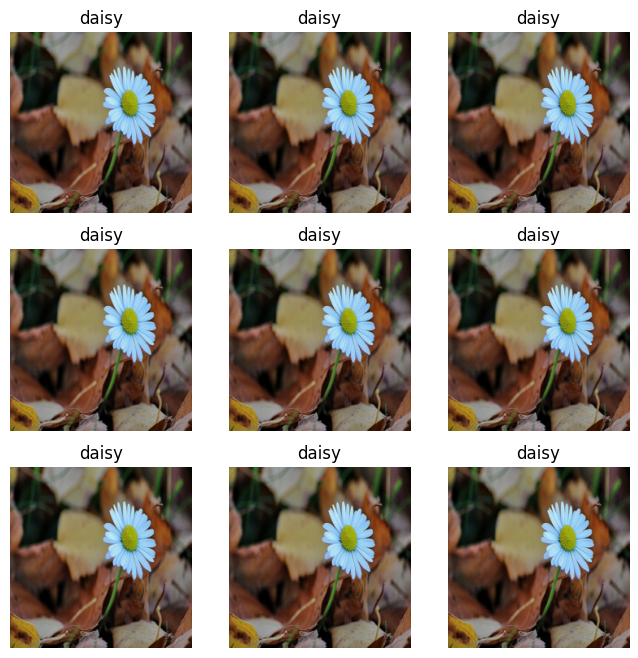

In [62]:
labels_map = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = inv_normalize(images[sample_idx]).permute(1,2,0), labels[sample_idx]   # Inv_normalise to get tensor from a normalised range to [0,1] range
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")    # Permote is used brfore to convert tensor of format [3,224,224] to [224,224,3]
plt.show()

# Training start

In [63]:
# Create a model Class that inherits nn.module to make a simple neural network
class model(nn.Module):
  # Input layer (224*3) inputs ---> Hidden layer 1 (128) --> Output Layer (5) --> Softmax(Output)
  def __init__(self, in_feature = 224*224*3, hidden_layer_1 = 16, out_features = 5):
    super().__init__()    # Instantiate our nn.module class
    self.fc1 = nn.Linear(in_feature, hidden_layer_1)
    self.out = nn.Linear(hidden_layer_1, out_features)
    self.relu = nn.ReLU()
  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.out(x)
    return x

In [ ]:
torch.manual_seed(41)
Model = model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Model.parameters(), lr = 0.001)
num_epochs = 10
loss_values=[]
training_accuracy = []
validation_accuracy = []
Model.train()

for epoch in range(num_epochs):
    running_loss = 0.0  # Reset for each epoch

    for images, labels in train_dataset:
        # 1. Forward pass
        outputs = Model(images.permute(0,2,3,1).reshape(images.size(0), -1))
        loss = criterion(outputs, labels)

        # 2. Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 3. ACCUMULATE LOSS (Crucial Step)
        running_loss += loss.item()

    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_dataset)
    loss_values.append(avg_loss)

    # Evaluation of the model on every epoch on validation data
    pred_actual_pairs_val = []
    with torch.no_grad():
      for images, label in val_dataset:
        y_eval = Model(images.permute(0,2,3,1).reshape(images.size(0), -1))
        for i in range(len(y_eval)):
          pred_actual_pairs_val.append((torch.argmax(y_eval[i]).item(), int(label[i])))
    y_pred = np.array([p for p, a in pred_actual_pairs_val])
    y_true = np.array([a for p, a in pred_actual_pairs_val])
    validation_accuracy_instance = (y_pred == y_true).mean()
    validation_accuracy.append(validation_accuracy_instance)

    # Evaluation of the model on every epoch on training data
    pred_actual_pairs_train = []
    with torch.no_grad():
      for images, label in train_dataset:
        y_eval = Model(images.permute(0,2,3,1).reshape(images.size(0), -1))
        for i in range(len(y_eval)):
          pred_actual_pairs_train.append((torch.argmax(y_eval[i]).item(), int(label[i])))
    y_pred = np.array([p for p, a in pred_actual_pairs_train])
    y_true = np.array([a for p, a in pred_actual_pairs_train])
    training_accuracy_instance = (y_pred == y_true).mean()
    training_accuracy.append(training_accuracy_instance)

    print(f"Epoch {epoch+1}, Loss: {avg_loss}")

Epoch 1, Loss: 9.552117147931346
Epoch 2, Loss: 5.062794437011083
Epoch 3, Loss: 3.931761891753585
Epoch 4, Loss: 3.2854498856597476
Epoch 5, Loss: 2.7358073128594294
Epoch 6, Loss: 2.290395929305642
Epoch 7, Loss: 1.7038321710295148
Epoch 8, Loss: 1.5599916257240154
Epoch 9, Loss: 1.6979416879238907
Epoch 10, Loss: 1.2840636372566223


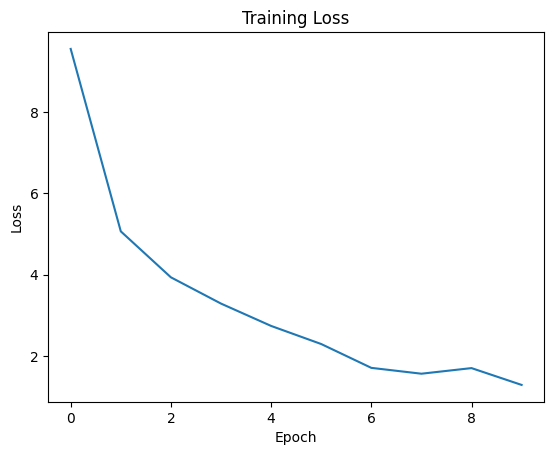

In [66]:
plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

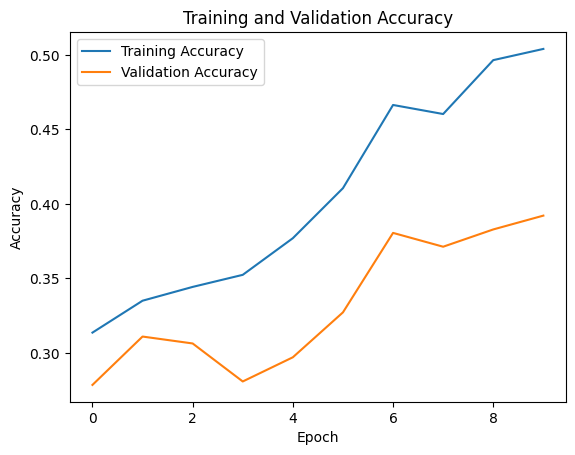

In [67]:
plt.plot(training_accuracy, label="Training Accuracy")
plt.plot(validation_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

# Test

In [68]:
pred_actual_pairs = []
with torch.no_grad():
  for images, label in test_dataset:
    y_eval = Model(images.permute(0,2,3,1).reshape(images.size(0), -1))
    pred_actual_pairs.append({torch.argmax(y_eval), int(label)})
    # print(f'Prediction: {torch.argmax(y_eval)} \t Actual: {int(label)}')

Overall Accuracy: 0.4005
           daisy  dandelion  rose  sunflower  tulip
daisy         34         35     5          3      6
dandelion     32         53     3         14      4
rose           5         23    26          2     12
sunflower      4         28     2         31      6
tulip         10         40    22          3     29
              precision    recall  f1-score   support

       daisy     0.4000    0.4096    0.4048        83
   dandelion     0.2961    0.5000    0.3719       106
        rose     0.4483    0.3824    0.4127        68
   sunflower     0.5849    0.4366    0.5000        71
       tulip     0.5088    0.2788    0.3602       104

    accuracy                         0.4005       432
   macro avg     0.4476    0.4015    0.4099       432
weighted avg     0.4387    0.4005    0.4029       432

daisy       : 0.4096
dandelion   : 0.5000
rose        : 0.3824
sunflower   : 0.4366
tulip       : 0.2788
Macro Precision: 0.44760856754914913
Macro Recall   : 0.4014914735098

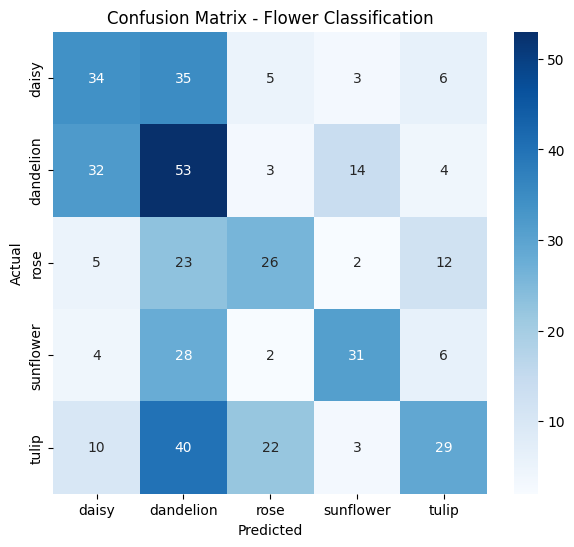

In [70]:
y_pred = np.array([p for p, a in pred_actual_pairs])
y_true = np.array([a for p, a in pred_actual_pairs])

accuracy = (y_pred == y_true).mean()
print(f"Overall Accuracy: {accuracy:.4f}")

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=labels_map, columns=labels_map)
print(cm_df)

report = classification_report(
    y_true,
    y_pred,
    target_names=labels_map,
    digits=4
)
print(report)

per_class_acc = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(per_class_acc):
    print(f"{labels_map[i]:12s}: {acc:.4f}")

print("Macro Precision:", precision_score(y_true, y_pred, average='macro'))
print("Macro Recall   :", recall_score(y_true, y_pred, average='macro'))
print("Macro F1       :", f1_score(y_true, y_pred, average='macro'))
print("Weighted F1    :", f1_score(y_true, y_pred, average='weighted'))

plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Flower Classification")
plt.show()